## TODO:

 * extract to class in .py file for better code reuse and overall cleanness. Separate the graphs in different sessions so that we can evaluate and infer while training at the same time.
 * better batching mechanism (maybe the prebuilt in TF)
 * try different optimizer (SGD with momentum, RMSProp) ?
 * learning rate decay ?
 * dropout, more layers, gradient clipping, bidirectional, ... ?
 * beam search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import nltk
import tensorflow as tf
import itertools

## Prepare vocabulary and a training set

I load the Sherlock holmes corpus and process it as follows:
 * All is converted to lowercase, all whitespace collapsed to a single space
 * nltk is used to tokenize into sentences and words. Special tokens START and END are added to the beginning and end of each sentence
 * Only first 100 sentences are used for training (for simplicity)
 * All words are kept. Later we may drop all words frequent less than a threshold, or replace them with UNKNOWN token
 * Longer sentences are trimmed to length of 50 words, shorter sentences are padded (and masking is used in the training).

In [2]:
with open('../txa-hw/hw2/pg1661.txt', encoding='utf-8') as f:
    original_text = f.read()
# Strip meta info and table of contents at the beginning and licence at the end -> use only the book itself.
text = original_text[re.search('ADVENTURE I', original_text).start() : re.search('End of the Project Gutenberg EBook', original_text).start()]
text = text.lower().strip()
text = re.sub('\s+', ' ', text) # replace whitespaces with single space

In [3]:
sentences = nltk.sent_tokenize(text)

token_start = 'START'
token_end = 'END'
tok_sentences = [[token_start] + [w for w in nltk.word_tokenize(s) if w] + [token_end] for s in sentences]

train_size = 100  # limit training set to this number of first sentences
tok_sentences = tok_sentences[:train_size]

In [4]:
freq_dist = nltk.FreqDist(itertools.chain(*tok_sentences))

freq_threshold = 0
vocab = [(k,v) for k,v in freq_dist.items() if v >= freq_threshold]
vocab_size = len(vocab)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}

# drop all words not in vocabulary (less frequent than freq_threshold)
# maybe to replace them with special token would be better?
# now we actually don't drop anything
tok_sentences = [[w for w in s if w in word_id] for s in tok_sentences]

max_len = 50

# cut all sentences to max_len
tok_sentences = [s[:max_len] for s in tok_sentences]

In [22]:
vocab_size

662

In [5]:
X = [[word_id[w] for w in s[:-1]] for s in tok_sentences]
Y = [[word_id[w] for w in s[1:]] for s in tok_sentences]  # shift-by-1 X, next-word prediction

X_lens = np.asarray([len(x) for x in X])
# Y_lens = [len(y) for y in Y]

# pad with zeros to max_len
X = np.asarray([np.pad(x, (0,max_len-len(x)), 'constant') for x in X])
Y = np.asarray([np.pad(y, (0,max_len-len(y)), 'constant') for y in Y])

## Build train and eval graphs

Two TensorFlow graphs are built. One for training and second for evaluation.

Architecture:
 * embedding layer (no bias, no activation) maps word indices to a dense vectors
 * RNN layer using LSTM cell
 * projection layer (bias, no activation) projecting RNN outputs to logits of size(vocabulary)
 * softmax layer providing us with nex_word probability distribution.
 
So far, both graps are the same.

In [6]:
num_steps = max_len  # max. number of timesteps
embeding_size = 100
input_size = X.shape[0]
batch_size = 32
lstm_size = 100 # n_hidden and state_size?

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [8]:
def build_model(input_, input_lengths, target):
    # Embedding layer
    embedding = tf.get_variable('E', initializer=tf.truncated_normal([vocab_size, embeding_size]))   # [V, E]
    embedded_input = tf.nn.embedding_lookup(embedding, input_) # [B, T, E]

    # RNN layer
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    outputs, final_state = tf.nn.dynamic_rnn(lstm, embedded_input, dtype=tf.float32, sequence_length=input_lengths)

    # Projection and softmax
    softmax_w = tf.get_variable('W_softmax', initializer=tf.truncated_normal([lstm_size, vocab_size]), dtype=tf.float32)   # [lstm_size, V]
    softmax_b = tf.get_variable('b_softmax', initializer=tf.zeros([vocab_size]))   # [V]
    logits = tf.tensordot(outputs, softmax_w, axes=[[2],[0]]) + tf.reshape(softmax_b, [1,1,-1]) # [B, T, V]
    probabilities = tf.nn.softmax(logits) # [B, T, V]
    return logits, probabilities

In [9]:
train_input = tf.placeholder(tf.int32, [batch_size, num_steps], name='train_input')   # [B, T]
train_input_lengths = tf.placeholder(tf.int32, [batch_size], name='train_input_lengths')   # [B]
train_target  = tf.placeholder(tf.int32, [batch_size, num_steps], name='train_target')   # [B, T]

eval_input = tf.placeholder(tf.int32, [input_size, num_steps], name='eval_input')
eval_input_lengths = tf.placeholder(tf.int32, [input_size], name='eval_input_lengths')
eval_target  = tf.placeholder(tf.int32, [input_size, num_steps], name='eval_target')

In [10]:
with tf.variable_scope('root'):
    train_logits, train_probas = build_model(train_input, train_input_lengths, train_target)
with tf.variable_scope('root', reuse=True):
    eval_logits, eval_probas = build_model(eval_input, eval_input_lengths, eval_target)

## Calculate loss

Two losses are considered here. One is classic categorical cross-entropy which is used currently. The second one is taken from the Show and tell paper and it is a negative likelihood of a correct (target) word for each step:
$$\mathrm{loss} = - \sum_t \log p(\mathrm{correct\_word}_t)$$.
Both of them are averaged over number of sentences and over number of words in a sentence.

The loss is added to both of the graphs.

In [11]:
# https://stackoverflow.com/a/42606537
gather_p = lambda params, indices : tf.gather_nd(params, tf.stack([tf.tile(tf.expand_dims(tf.range(tf.shape(indices)[0]), 1), [1, tf.shape(indices)[1]]), tf.transpose(tf.tile(tf.expand_dims(tf.range(tf.shape(indices)[1]), 1), [1, tf.shape(indices)[0]])), indices], 2))

In [12]:
def build_loss_xent(logits, targets, input_lengths):
    ''' Crossentropy between probas and one-hot target. '''
    l = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    mask = tf.sequence_mask(input_lengths, maxlen=num_steps, dtype=tf.float32) # [B, T]
    masked_l = tf.multiply(l, mask)   # [B, T]. Masking by seq. lenghts
    loss = tf.reduce_sum(masked_l) / tf.reduce_sum(mask)
    return loss
    

def build_loss(probabilities, target, input_lengths):
    ''' Negative log-likelihood of a correct word. '''
    target_probas = gather_p(probabilities, target)   # [B, T]. Probabilities of the correct word
    log_likelihood = - tf.log(target_probas)   # [B, T]. Negative log likelihood
    mask = tf.sequence_mask(input_lengths, maxlen=num_steps, dtype=tf.float32) # [B, T]
    masked_ll = tf.multiply(log_likelihood, mask)   # [B, T]. Masking by seq. lenghts
    loss = tf.reduce_sum(masked_ll) / tf.reduce_sum(mask)  # average over number of sentences and over words in sentences
    return loss

In [13]:
# train_loss = build_loss(train_probas, train_target, train_input_lengths)
# eval_loss = build_loss(eval_probas, eval_target, eval_input_lengths)

train_loss = build_loss_xent(train_logits, train_target,train_input_lengths)
eval_loss = build_loss_xent(eval_logits, eval_target, eval_input_lengths)

## Train model

Model is trained by feeding mini-batches of sentences. Adam optimizer with learning rate 0.1 is used. The loss on all training set is calculated every 10 steps using eval graph.

In [14]:
learning_rate = 0.1
train_op = tf.train.AdamOptimizer(learning_rate).minimize(train_loss)

In [15]:
sess.run(tf.global_variables_initializer())
losses = []
step = 0

In [16]:
n_epochs = 100
num_batches = train_size // batch_size

def train():
    global step
    for epoch in range(n_epochs):
        print('epoch', epoch+1)
        idx = np.random.permutation(X.shape[0])
        loss_epoch = 0.0
        for i in range(num_batches):
            step += 1
            start = i*batch_size
            end = (i+1)*batch_size
            b_ids = idx[start:end]
            x, y, x_lens = X[b_ids], Y[b_ids], X_lens[b_ids]
            sess.run(train_op, feed_dict={
                train_input: x, 
                train_input_lengths: x_lens,
                train_target: y
            })
            if step % 10 == 0:
                loss_value = sess.run(eval_loss, feed_dict={
                    eval_input: X, 
                    eval_input_lengths: X_lens,
                    eval_target: Y
                })
                losses.append(loss_value)
    print('finished')


# %load_ext line_profiler
# %lprun -f train train()
train()

final_loss_value = sess.run(eval_loss, feed_dict={
    eval_input: X, 
    eval_input_lengths: X_lens,
    eval_target: Y
})

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
finished


final loss 0.246972


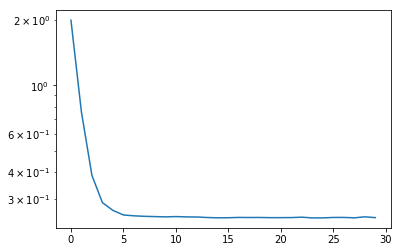

In [17]:
print('final loss', final_loss_value)
plt.semilogy(losses)

## Build infer graph

The next-word prediction is used to greedily generate sentences. For this purpose, a inference graph is created, that enables us to pass a word and a state of LSTM cell and get the new word and new state.

We can see that this simple model is quite overfit, the beginnings of the generated sentences largely match the sentences in the training set. This is on purpose to somewhat demonstrate the correctness that the model can actually learn the data.

In [18]:
def build_inference_graph(input_, input_lengths, state_feed):
    # Embedding layer
    embedding = tf.get_variable('E', initializer=tf.truncated_normal([vocab_size, embeding_size]))   # [V, E]
    embedded_input = tf.nn.embedding_lookup(embedding, input_) # [I, T, E]

    # RNN layer
    state_tuple = tf.contrib.rnn.LSTMStateTuple(*tf.unstack(state_feed, axis=0))
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    outputs, state = tf.nn.dynamic_rnn(lstm, embedded_input, dtype=tf.float32, sequence_length=input_lengths, initial_state=state_tuple)

    # Projection and softmax
    softmax_w = tf.get_variable('W_softmax', initializer=tf.truncated_normal([lstm_size, vocab_size]), dtype=tf.float32)   # [lstm_size, V]
    softmax_b = tf.get_variable('b_softmax', initializer=tf.zeros([vocab_size]))   # [V]
    logits = tf.tensordot(outputs, softmax_w, axes=[[2],[0]]) + tf.reshape(softmax_b, [1,1,-1]) # [B, T, V]
    probabilities = tf.nn.softmax(logits) # [B, T, V]
    return probabilities, state



In [19]:
infer_input = tf.placeholder(tf.int32, [None, 1], name='infer_input')   # [I]
infer_input_lengths = tf.placeholder(tf.int32, [None], name='infer_input_lengths')   # [I]
state_feed = tf.placeholder(dtype=tf.float32, shape=[2, 1, lstm_size], name='state_feed')  # [2, num_layers, lstm_size]

with tf.variable_scope('root', reuse=True):
    infer_probas, infer_final_state = build_inference_graph(infer_input, infer_input_lengths, state_feed)

## Generate text

In [21]:
seq = ['START']
seq = [word_id[s] for s in seq]
state = init_state = np.zeros((2, 1, lstm_size))

num_words = 100

for i in range(len(seq)-1, num_words):
    p, state = sess.run([infer_probas, infer_final_state], feed_dict={
        infer_input: np.reshape(seq[-1], (1,1)),
        infer_input_lengths: np.array([1]),
        state_feed: state
    })
#     max_id = np.argmax(p)
    p = p.reshape([-1])
    max_id = np.random.choice(list(range(len(p))), p=p)
    seq.append(max_id)
    if max_id == word_id[token_end]: # restart the sentence
        seq.append(word_id[token_start])
        state = init_state
print(' '.join(id_word[s] for s in seq))

START hold it up to the light . '' END START what do you deduce from it ? '' END START i have seldom heard him mention her under any other name . END START grit in a sensitive instrument , or a crack in one of his own high-power lenses , would not be more disturbing than a strong emotion in a nature such as his . END START the note was undated , and without either signature or address . END START he was at work again . END START `` how often ? '' END START `` how many ? END START `` such paper could
